In [145]:
import matplotlib.pyplot as plt
import os
import random
import cv2
from scipy import ndimage
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns

datadir = "jellybean-data"
if not os.path.exists(datadir):
    import sys
    !{sys.executable} -m pip install gitpython
    from git import Repo
    Repo.clone_from(r"git@github.com:srvanderplas/jellybean_data.git", r"jellybean-data")

Defaulting to user installation because normal site-packages is not writeable


KeyboardInterrupt: 

In [ ]:
## list the images in here
images = os.listdir(datadir)

In [ ]:
# take a random flavor
sample_path = os.path.join(datadir, random.sample(images,1)[0])
sample_path

In [ ]:
## list all images in the folder
samp_images = os.listdir(sample_path)

In [ ]:
# sample a random image
flavor = random.sample(samp_images,1)[0]
sample_path = os.path.join(sample_path, flavor)
sample_path

In [ ]:
sample_path
sample_image = plt.imread(sample_path)

In [ ]:
plt.imshow(sample_image)

In [ ]:
sample_image.shape

In [ ]:
from skimage.color import rgb2gray

In [ ]:
gray_mask = rgb2gray(sample_image)

In [ ]:
plt.imshow(gray_mask, "gray")
plt.show()

In [ ]:
gray_mask = cv2.convertScaleAbs(gray_mask*255)

In [ ]:
from skimage import exposure

img_eq = exposure.equalize_hist(gray_mask)

In [ ]:
plt.imshow(img_eq, "gray")
plt.show()

In [ ]:
from skimage.filters import threshold_otsu

In [ ]:
# get the otsu thresholding
img_threshold = threshold_otsu(img_eq)

In [ ]:
# threshold the image
binary = img_eq > img_threshold

In [ ]:
plt.imshow(binary, "gray")
plt.show()

In [ ]:
binary = 1- binary

In [ ]:
plt.imshow(binary, "gray")
plt.show()

In [ ]:
binary = cv2.convertScaleAbs(binary*255.0)

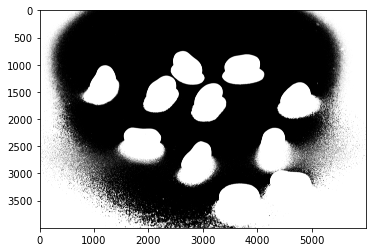

In [98]:
plt.imshow(binary, "gray")

In [99]:
fill_holes = ndimage.binary_fill_holes(binary)

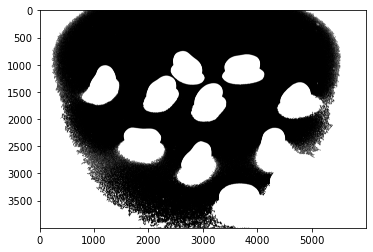

In [100]:
plt.imshow(fill_holes, "gray")

In [101]:
fill_holes = cv2.convertScaleAbs(fill_holes*255.0)

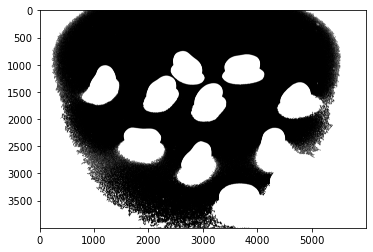

In [102]:
plt.imshow(fill_holes, "gray")

In [103]:
ret, markers = cv2.connectedComponents(fill_holes)

In [104]:
## detect contours
## and remove the biggest one
contours,hierarchy =  cv2.findContours(fill_holes,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [105]:
largest_contours = sorted(contours, key=cv2.contourArea)[-20:-1]

In [106]:
len(largest_contours)

19

In [107]:
# temp1 = np.zeros((fill_holes.shape[0], fill_holes.shape[1]))

In [108]:
# cv2.drawContours(temp1, largest_contours, -1, (255,255,255), -1)

In [109]:
# plt.imshow(temp1, "gray")


In [110]:
# img = mask_sample_bounded.reshape(mask_sample_bounded.shape[0]*mask_sample_bounded.shape[1],3)

  0%|          | 0/19 [00:00<?, ?it/s]

274863.5


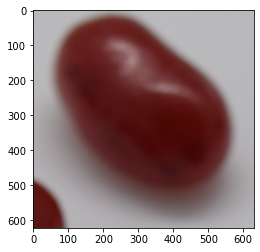

316447.0


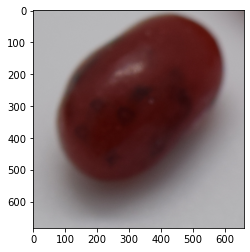

321431.0


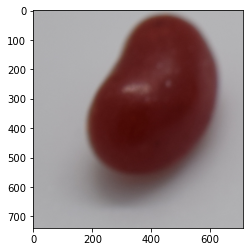

329949.5


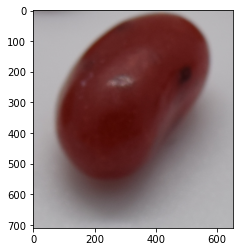

333212.5


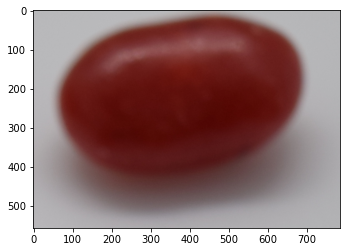

393959.5


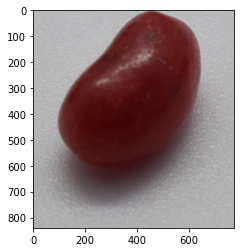

432745.5


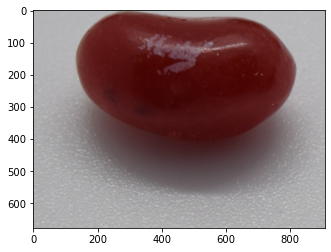

In [111]:
temp1 = np.zeros((fill_holes.shape[0], fill_holes.shape[1]))
catch_img = []
for cnt in tqdm(largest_contours): 
    area = cv2.contourArea(cnt)
#     temp = markers == cnt
#     temp = cv2.convertScaleAbs(temp*255.0)
    if (area > 10**5) & (area < 10**6):
        print(area)
        x,y,w,h = cv2.boundingRect(cnt)
        mask_sample_bounded = sample_image[y:y+h,x:x+w, :]
        plt.imshow(mask_sample_bounded)
        plt.show()
        cv2.drawContours(temp1, [cnt], -1, (255,255,255), -1)
        img = mask_sample_bounded.reshape(mask_sample_bounded.shape[0]*mask_sample_bounded.shape[1],3)
        mean_rgb = img.mean(0)
        std_rgb = img.std(0)
        mean_by_std = mean_rgb/std_rgb
        all_catch = [mean_rgb, std_rgb, mean_by_std]
        all_catch = [it for item in all_catch for it in item]
        catch_img.append(all_catch)
catch_img_df = pd.DataFrame(catch_img)
catch_img_df.columns = ["r_mean", "g_mean", "b_mean", "r_std", "g_std", "b_std", "r_mean_by_std", 
                       "g_mean_by_std", "b_mean_by_std"]
catch_img_df["flavor"] = flavor

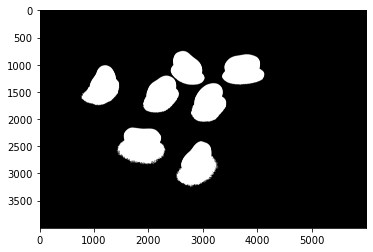

In [112]:
plt.imshow(temp1, "gray")
plt.show()

In [113]:
def get_features_image(sample_path): 
    flavor = sample_path.split("/")[-2]
    sample_image = plt.imread(sample_path)
    gray_mask = rgb2gray(sample_image)
    gray_mask = cv2.convertScaleAbs(gray_mask*255)
    img_eq = exposure.equalize_hist(gray_mask)
    # get the otsu thresholding
    img_threshold = threshold_otsu(img_eq)
    # threshold the image
    binary = img_eq > img_threshold
    binary = 1- binary
    binary = cv2.convertScaleAbs(binary*255.0)
    fill_holes = ndimage.binary_fill_holes(binary)
    fill_holes = cv2.convertScaleAbs(fill_holes*255.0)
    ## detect contours
    ## and remove the biggest one
    contours,hierarchy =  cv2.findContours(fill_holes,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    largest_contours = sorted(contours, key=cv2.contourArea)[-20:-1]
    
    if len(largest_contours) != 19:
        return []
#     img = sample_image.reshape(sample_image.shape[0]*sample_image.shape[1],3)

    temp1 = np.zeros((fill_holes.shape[0], fill_holes.shape[1]))
    catch_img = []
    for cnt in largest_contours: 
        area = cv2.contourArea(cnt)
#     temp = markers == cnt
#     temp = cv2.convertScaleAbs(temp*255.0)
        if (area > 10**5) & (area < 10**6):
#             print(area)
            x,y,w,h = cv2.boundingRect(cnt)
            mask_sample_bounded = sample_image[y:y+h,x:x+w, :]
#             plt.imshow(mask_sample_bounded)
#             plt.show()
            cv2.drawContours(temp1, [cnt], -1, (255,255,255), -1)
            img = mask_sample_bounded.reshape(mask_sample_bounded.shape[0]*mask_sample_bounded.shape[1],3)
            mean_rgb = img.mean(0)
            std_rgb = img.std(0)
            mean_by_std = mean_rgb/std_rgb
            all_catch = [mean_rgb, std_rgb, mean_by_std]
            all_catch = [it for item in all_catch for it in item]
            catch_img.append(all_catch)
            
    catch_img_df = pd.DataFrame(catch_img)
#     if len(catch_img) !=
    catch_img_df.columns = ["r_mean", "g_mean", "b_mean", "r_std", "g_std", "b_std", "r_mean_by_std", 
                       "g_mean_by_std", "b_mean_by_std"]
    catch_img_df["flavor"] = flavor

    return catch_img_df

In [114]:
catch_img_df = get_features_image(sample_path)

In [115]:
catch_img_df.head()

,r_mean,g_mean,b_mean,r_std,g_std,b_std,r_mean_by_std,g_mean_by_std,b_mean_by_std,flavor
0,131.081105,99.967358,100.600490,40.742415,66.898725,68.504424,3.217313,1.494309,1.468525,strawberry_jam
1,125.070198,101.210717,102.257250,45.868706,67.684046,69.208844,2.726700,1.495341,1.477517,strawberry_jam
2,140.025827,118.253168,119.343601,38.670405,64.591376,66.239486,3.621007,1.830789,1.801699,strawberry_jam
3,133.241932,104.677231,105.534084,38.345818,64.556073,66.653371,3.474745,1.621493,1.583327,strawberry_jam
4,132.140031,94.698855,94.251390,35.863422,66.008948,68.548790,3.684535,1.434637,1.374953,strawberry_jam


In [131]:
out_path =  "./"

In [117]:
# out_path

In [139]:
flavors = os.listdir(datadir)
flavors.remove(".git")
flavors.remove("LICENSE")
flavors

['very_cherry',
 'cappuchino',
 'plum',
 'mixed_berry_smoothie',
 'strawberry_daquiry',
 'bubble_gum',
 'aw_root_beer',
 'sour_cherry',
 'green_apple',
 'buttered_popcorn',
 'lemon_drop',
 'chili_mango',
 'peach',
 'sunkist_grapefruit',
 'dr_pepper',
 'berry_blue',
 'sunkist_lemon',
 'cotton_candy',
 'pomegranate',
 'sizzling_cinnamon',
 'strawberry_cheesecake',
 'mango',
 'top_banana',
 'juicy_pear',
 'wild_blackberry',
 'island_punch',
 'cantaloupe',
 'toasted_marshmallow',
 'kiwi',
 'sunkist_lime',
 'crushed_pineapple',
 'tutti_fruitti',
 'cinnamon',
 'raspberry',
 'chocolate_pudding',
 'watermelon',
 'french_vanilla',
 'strawberry_jam',
 'aw_cream_soda',
 'lemon_lime',
 'licorice',
 'sunkist_tangerine',
 'margarita',
 'coconut',
 'red_apple',
 'blueberry',
 'orange_sherbet',
 'caramel_corn',
 'pina_colada',
 'sunkist_orange']

In [140]:
import random

In [120]:
# flavors = random.sample(flavors, 20)

In [141]:
sample_paths = []

for flv in flavors:
    sample_path1 = os.path.join(datadir, flv)
    # print(sample_path1)
    samp_images = os.listdir(sample_path1)
    for imgs in samp_images:
        sample_path = os.path.join(sample_path1, imgs)
        sample_paths.append(sample_path)

In [142]:
len(sample_paths)

612

In [143]:
from joblib import Parallel, delayed

In [144]:
catch_all_dfs = Parallel(n_jobs=7, verbose = 6, 
                        backend = "loky")(delayed(get_features_image)(i) for i in sample_paths)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   23.1s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:   51.4s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 299 tasks      | elapsed:  2.4min
[Parallel(n_jobs=7)]: Done 590 tasks      | elapsed:  2.4min


FileNotFoundError: [Errno 2] No such file or directory: '../jellybean-data/island_punch/DSC_0008.JPG'

In [ ]:
# catch_all_dfs = []

# for sample_path in tqdm(sample_paths): 
#     if len(get_features_image(sample_path)) > 0:
#         catch_all_dfs.append(get_features_image(sample_path))

In [ ]:
catch_all_dfs_1 = [item for item in catch_all_dfs if len(item) > 0]

In [ ]:
catch_all_dfs_1 = pd.concat(catch_all_dfs_1)

In [ ]:
current_dir

In [ ]:
out_path =  os.path.join(current_dir, "../", "Case_Study_and_Misc")

In [ ]:
catch_all_dfs_1.to_csv(os.path.join(out_path, "all.csv"), index = False)

In [ ]:
catch_all_dfs_1.isnull().sum()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
top_k = catch_all_dfs_1["flavor"].value_counts()[:20].index

In [ ]:
catch_all_dfs_1 = catch_all_dfs_1[catch_all_dfs_1["flavor"].isin(top_k)]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(catch_all_dfs_1.iloc[:,:-1], catch_all_dfs_1.iloc[:,-1], 
                                    test_size = 0.3, stratify = catch_all_dfs_1.iloc[:,-1])

In [ ]:
count_train = pd.DataFrame(y_train).value_counts().reset_index()
count_train.columns = ["flavor", "counts"]

In [ ]:
count_train

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.figure(figsize = (10,5))
sns.barplot(data = count_train, x = "flavor", y = "counts")
plt.xticks(rotation = 90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Flavor", weight = "bold", fontsize = 20)
plt.ylabel("Frequency", weight = "bold", fontsize = 20)
# plt.legend(prop={'size': 15})
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier


In [ ]:
rf = RandomForestClassifier(n_jobs=6)

parameters = {'n_estimators':[100]}

In [ ]:
gs = GridSearchCV(estimator=rf, cv=5, n_jobs=6, scoring="accuracy", param_grid = parameters, verbose = 5)

In [ ]:
gs.fit(x_train, y_train)

gs.best_score_

In [ ]:
gs.best_estimator_

In [ ]:
y_test_pred = gs.predict(x_test)

In [ ]:
np.mean(y_test_pred == y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf = confusion_matrix(y_test, y_test_pred, normalize = "true", labels = top_k)

In [ ]:
df_cf = pd.DataFrame(cf, columns=top_k, index = top_k)

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.figure(figsize = (10,5))
sns.barplot(data = count_train, x = "flavor", y = "counts")
plt.xticks(rotation = 90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Flavor", weight = "bold", fontsize = 20)
plt.ylabel("Frequency", weight = "bold", fontsize = 20)
# plt.legend(prop={'size': 15})
plt.show()

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.figure(figsize = (10,10))
sns.heatmap(df_cf, cmap = "RdBu_r")
plt.xlabel("Predicted Flavor", weight = "bold", fontsize = 20)
plt.ylabel("True Flavor", weight = "bold", fontsize = 20)
plt.show()

In [ ]:
rf = gs.best_estimator_

In [ ]:
rf.fit(x_train, y_train)

In [ ]:
rf.feature_importances_

In [ ]:
rf.feature_names_in_

In [ ]:
feat_score = zip(rf.feature_names_in_, rf.feature_importances_)

In [ ]:
feat_score_df = pd.DataFrame(list(feat_score))

In [ ]:
feat_score_df.columns = ["feature_name", "importance_score"]

In [ ]:
imp_df = feat_score_df.sort_values("importance_score", ascending = False).reset_index(drop = True)

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.figure(figsize = (10,5))
sns.barplot(data = imp_df, x = "feature_name", y = "importance_score")
plt.xticks(rotation = 90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Feature Name", weight = "bold", fontsize = 20)
plt.ylabel("Importance Score", weight = "bold", fontsize = 20)
plt.show()